In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random

from diffdeb.config import get_config_LDM
from diffdeb.diffusion import backward_denoising_ddpm, inverse_prob_ddpm_step
from diffdeb.load_weights import load_model_weights
from diffdeb.models import Decoder, Encoder, UNet

# from flax.training import orbax_utils

In [ ]:
rng = random.key(42)
config = get_config_LDM()

In [ ]:
encoder_model = encoder_model = Encoder(
    latent_dim=config.vae_config.latent_dim,
    filters=config.vae_config.encoder_filters,
    kernels=config.vae_config.encoder_kernels,
    dense_layer_units=config.vae_config.dense_layer_units,
)
decoder_model = Decoder(
    input_shape=config.vae_config.input_shape,
    latent_dim=config.vae_config.latent_dim,
    filters=config.vae_config.decoder_filters,
    kernels=config.vae_config.decoder_kernels,
    dense_layer_units=config.vae_config.dense_layer_units,
)
rng, key = random.split(rng)
UNet_model = UNet().init(key, (jnp.ones((1, 16, 1)), jnp.ones(1)))

In [ ]:
import os

In [ ]:
from diffdeb.dataset import batched_CATSIMDataset

ds_isolated_train, ds_isolated_val = batched_CATSIMDataset(
    tf_dataset_dir=os.path.join(
        "/sps/lsst/users/bbiswas/simulations/LSST/",
        "isolated_tfDataset",
    ),
    linear_norm_coeff=config.diffusion_config.linear_norm_coeff,
    batch_size=config.diffusion_config.batch_size,
    x_col_name="blended_gal_stamps",
    y_col_name="isolated_gal_stamps",
)

ds_isolated_train = ds_isolated_train.as_numpy_iterator()
ds_isolated_val = ds_isolated_val.as_numpy_iterator()

2024-08-01 07:40:09.712288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 07:40:09.712384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 07:40:09.715062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 07:40:12.356720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
batch = next(ds_isolated_val)

In [ ]:
noiseless_galaxy1 = batch[1][0]
noiseless_galaxy2 = batch[1][1]

In [ ]:
noiseless_galaxy1.shape

(45, 45, 6)

In [ ]:
padding_info1 = ((10, 13), (10, 14), (0, 0))
padding_info2 = ((13, 10), (14, 10), (0, 0))

In [ ]:
padding_infos = (padding_info1, padding_info2)

In [ ]:
noiseless_galaxy1 = jnp.pad(noiseless_galaxy1, padding_infos[0])

In [ ]:
noiseless_galaxy2 = jnp.pad(noiseless_galaxy2, padding_infos[1])

In [ ]:
noisy_field = noiseless_galaxy1 + noiseless_galaxy2
key, rng = jax.random.split(rng, 2)
noisy_field = (
    jax.random.normal(key, noisy_field.shape) * config.vae_config.noise_sigma
    + noisy_field
)

In [ ]:
config.vae_config.noise_sigma

Array([0.00394167, 0.01552871, 0.03564507, 0.04285481, 0.05007842,
       0.05390767], dtype=float32)

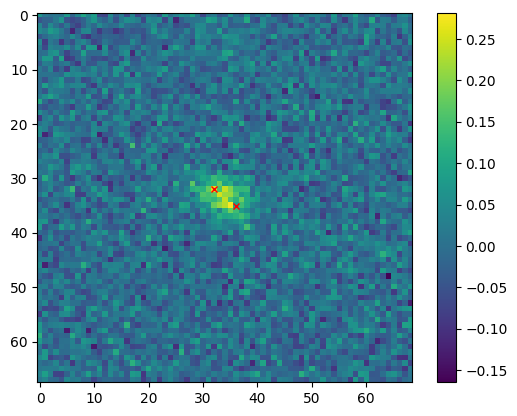

In [ ]:
plt.imshow(noisy_field[:, :, 3])
plt.plot(32, 32, marker="x", markersize=5, color="red")
plt.plot(36, 35, marker="x", markersize=5, color="red")
plt.colorbar()

In [ ]:
jnp.expand_dims(noisy_field, 0).shape

(1, 68, 69, 6)

# Check noisy latent images

In [ ]:
encoder_params = load_model_weights(config.vae_config)["encoder"]
decoder_params = load_model_weights(config.vae_config)["decoder"]
vae_params = load_model_weights(config.vae_config)

UNet_pararms = load_model_weights(config.diffusion_config)

Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 69
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 69
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/vae and step 69
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/UNet
Loading model weights from /pbs/throng/lsst/users/bbiswas/DiffDeblender/diffdeb/data/UNet and step 103


In [ ]:
def UNET_apply(UNet_pararms, x, t):
    return UNet().apply({"params": UNet_pararms}, (x, t))


vmapped_unet = jax.vmap(UNET_apply, (None, 0, None))

In [ ]:
x = jnp.ones(500)
x = x.at[0].set(0)

In [ ]:
x

Array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

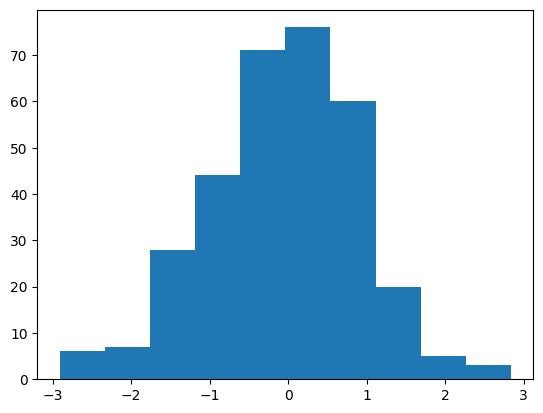

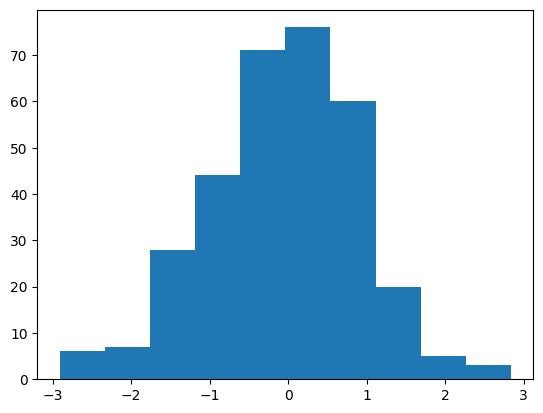

Array((), dtype=key<fry>) overlaying:
[2845666177 2900995437]


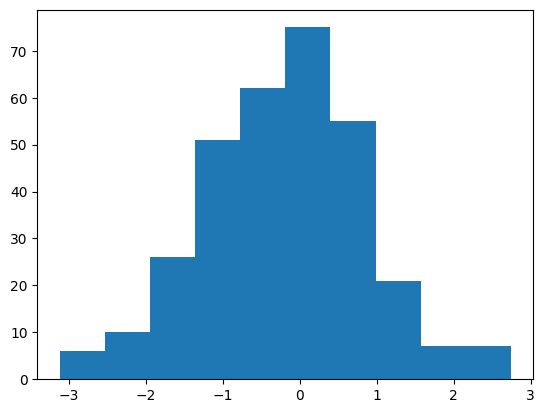

TIMESTEP: 499
Array((), dtype=key<fry>) overlaying:
[ 481306491 2112690179]
TIMESTEP: 498
Array((), dtype=key<fry>) overlaying:
[ 731482165 3576546721]
TIMESTEP: 497
Array((), dtype=key<fry>) overlaying:
[1438209935 3935000032]
TIMESTEP: 496
Array((), dtype=key<fry>) overlaying:
[ 991371323 2293320336]
TIMESTEP: 495
Array((), dtype=key<fry>) overlaying:
[1876349235 3400808464]
TIMESTEP: 494
Array((), dtype=key<fry>) overlaying:
[3003165084 3666077191]
TIMESTEP: 493
Array((), dtype=key<fry>) overlaying:
[2794023701  124988539]
TIMESTEP: 492
Array((), dtype=key<fry>) overlaying:
[1995982247 2934260131]
TIMESTEP: 491
Array((), dtype=key<fry>) overlaying:
[3519131935 2544562112]
TIMESTEP: 490
Array((), dtype=key<fry>) overlaying:
[3456606152  537774428]
TIMESTEP: 489
Array((), dtype=key<fry>) overlaying:
[2255120495 2166931859]
TIMESTEP: 488
Array((), dtype=key<fry>) overlaying:
[2062307348 3692661363]
TIMESTEP: 487
Array((), dtype=key<fry>) overlaying:
[1438731328 1790895789]
TIMESTEP: 48

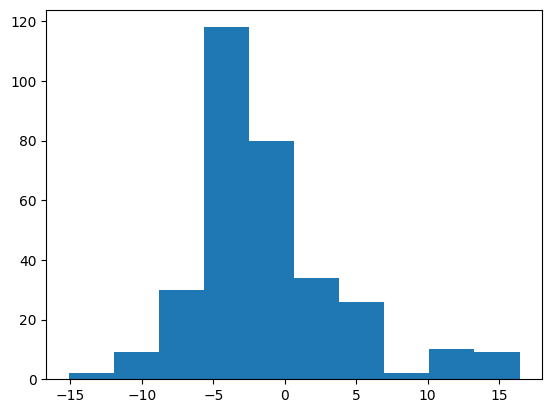

TIMESTEP: 474
Array((), dtype=key<fry>) overlaying:
[ 526550860 2159257519]
TIMESTEP: 473
Array((), dtype=key<fry>) overlaying:
[ 576871437 1507202363]
TIMESTEP: 472
Array((), dtype=key<fry>) overlaying:
[1229787360 2312665366]
TIMESTEP: 471
Array((), dtype=key<fry>) overlaying:
[1089228386  389671984]
TIMESTEP: 470
Array((), dtype=key<fry>) overlaying:
[2060554651 1272371193]
TIMESTEP: 469
Array((), dtype=key<fry>) overlaying:
[3804446065  213460030]
TIMESTEP: 468
Array((), dtype=key<fry>) overlaying:
[ 536758878 1452497422]
TIMESTEP: 467
Array((), dtype=key<fry>) overlaying:
[2208057184 2117360992]
TIMESTEP: 466
Array((), dtype=key<fry>) overlaying:
[ 610979379 1094305629]
TIMESTEP: 465
Array((), dtype=key<fry>) overlaying:
[254114233 810881956]
TIMESTEP: 464
Array((), dtype=key<fry>) overlaying:
[3998487640 2560516460]
TIMESTEP: 463
Array((), dtype=key<fry>) overlaying:
[3945839659 1225142266]
TIMESTEP: 462
Array((), dtype=key<fry>) overlaying:
[ 176110871 1989189705]
TIMESTEP: 461


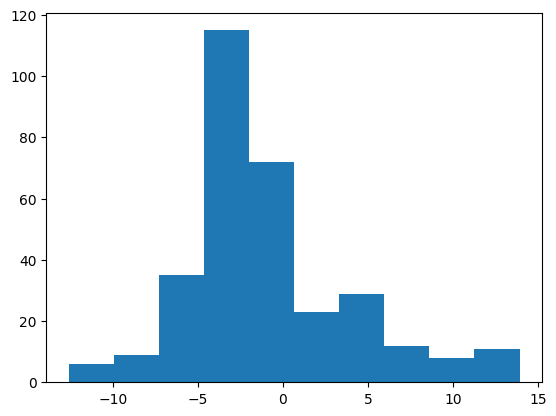

TIMESTEP: 449
Array((), dtype=key<fry>) overlaying:
[1557898239  296713963]
TIMESTEP: 448
Array((), dtype=key<fry>) overlaying:
[2842153485   36244605]
TIMESTEP: 447
Array((), dtype=key<fry>) overlaying:
[ 394434306 3973195664]
TIMESTEP: 446
Array((), dtype=key<fry>) overlaying:
[3709769797 2826195631]
TIMESTEP: 445
Array((), dtype=key<fry>) overlaying:
[4010897484 3975011953]
TIMESTEP: 444
Array((), dtype=key<fry>) overlaying:
[2573584495 1824570715]
TIMESTEP: 443
Array((), dtype=key<fry>) overlaying:
[3139361044  553635399]
TIMESTEP: 442
Array((), dtype=key<fry>) overlaying:
[ 675346652 3359382570]
TIMESTEP: 441
Array((), dtype=key<fry>) overlaying:
[1404904944 1061745583]
TIMESTEP: 440
Array((), dtype=key<fry>) overlaying:
[3326986114 3832656572]
TIMESTEP: 439
Array((), dtype=key<fry>) overlaying:
[3175235440 3416503992]
TIMESTEP: 438
Array((), dtype=key<fry>) overlaying:
[4149791347 2761500165]
TIMESTEP: 437
Array((), dtype=key<fry>) overlaying:
[4209334617  139948975]
TIMESTEP: 43

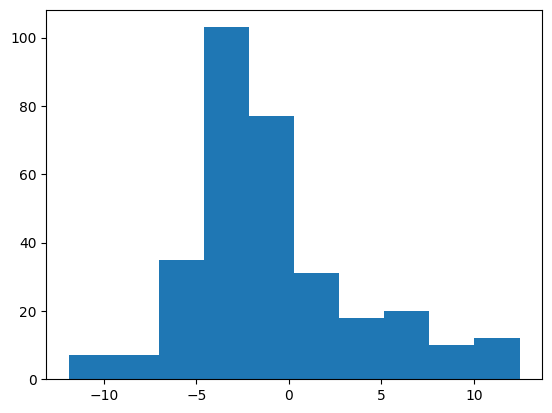

TIMESTEP: 424
Array((), dtype=key<fry>) overlaying:
[1973782346 2582038349]
TIMESTEP: 423
Array((), dtype=key<fry>) overlaying:
[1084346103 4015252388]
TIMESTEP: 422
Array((), dtype=key<fry>) overlaying:
[3354306453 2267466807]
TIMESTEP: 421
Array((), dtype=key<fry>) overlaying:
[ 710006914 1682512951]
TIMESTEP: 420
Array((), dtype=key<fry>) overlaying:
[ 905098913 3812377986]
TIMESTEP: 419
Array((), dtype=key<fry>) overlaying:
[3636652786  935621439]
TIMESTEP: 418
Array((), dtype=key<fry>) overlaying:
[1445316845 4070095310]
TIMESTEP: 417
Array((), dtype=key<fry>) overlaying:
[3236701971   60142799]
TIMESTEP: 416
Array((), dtype=key<fry>) overlaying:
[3839301705 1395856073]
TIMESTEP: 415
Array((), dtype=key<fry>) overlaying:
[494082807 769230130]
TIMESTEP: 414
Array((), dtype=key<fry>) overlaying:
[ 150801526 2438637441]
TIMESTEP: 413
Array((), dtype=key<fry>) overlaying:
[4148881382  241369172]
TIMESTEP: 412
Array((), dtype=key<fry>) overlaying:
[ 483193271 1974480336]
TIMESTEP: 411


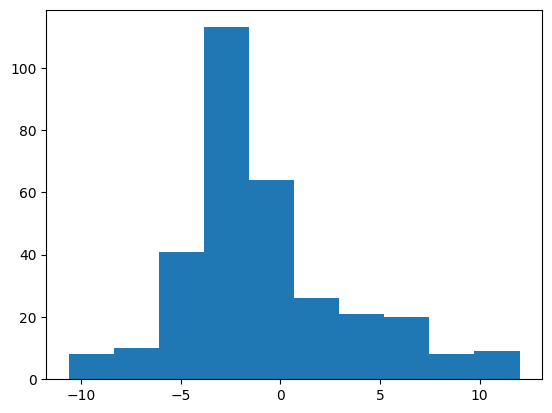

TIMESTEP: 399
Array((), dtype=key<fry>) overlaying:
[3093470515  464379660]
TIMESTEP: 398
Array((), dtype=key<fry>) overlaying:
[493420874 788513702]
TIMESTEP: 397
Array((), dtype=key<fry>) overlaying:
[2458118697 1490572416]
TIMESTEP: 396
Array((), dtype=key<fry>) overlaying:
[ 809888594 1419707682]
TIMESTEP: 395
Array((), dtype=key<fry>) overlaying:
[4154786910 1826950868]
TIMESTEP: 394
Array((), dtype=key<fry>) overlaying:
[419292045 765101814]
TIMESTEP: 393
Array((), dtype=key<fry>) overlaying:
[1177978552 1711601888]
TIMESTEP: 392
Array((), dtype=key<fry>) overlaying:
[3718696409 2645298956]
TIMESTEP: 391
Array((), dtype=key<fry>) overlaying:
[1882053680 1320229460]
TIMESTEP: 390
Array((), dtype=key<fry>) overlaying:
[131317410 256207159]
TIMESTEP: 389
Array((), dtype=key<fry>) overlaying:
[ 967839437 2303410097]
TIMESTEP: 388
Array((), dtype=key<fry>) overlaying:
[3747002495 3177239883]
TIMESTEP: 387
Array((), dtype=key<fry>) overlaying:
[3551318065 4186442369]
TIMESTEP: 386
Arra

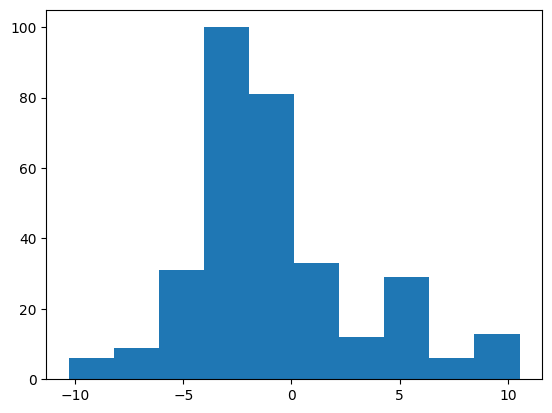

TIMESTEP: 374
Array((), dtype=key<fry>) overlaying:
[1615193084 1613221389]
TIMESTEP: 373
Array((), dtype=key<fry>) overlaying:
[1788470820 2810471227]
TIMESTEP: 372
Array((), dtype=key<fry>) overlaying:
[2394025329 2185211647]
TIMESTEP: 371
Array((), dtype=key<fry>) overlaying:
[ 498551547 2710176348]
TIMESTEP: 370
Array((), dtype=key<fry>) overlaying:
[1719230990 1805313090]
TIMESTEP: 369
Array((), dtype=key<fry>) overlaying:
[1576813607  643991473]
TIMESTEP: 368
Array((), dtype=key<fry>) overlaying:
[1507421850 1929530392]
TIMESTEP: 367
Array((), dtype=key<fry>) overlaying:
[3407680905 2113750523]
TIMESTEP: 366
Array((), dtype=key<fry>) overlaying:
[3296586392 3645704844]
TIMESTEP: 365
Array((), dtype=key<fry>) overlaying:
[814316386 960632592]
TIMESTEP: 364
Array((), dtype=key<fry>) overlaying:
[1990650595 2511581033]
TIMESTEP: 363
Array((), dtype=key<fry>) overlaying:
[ 292574611 2201989634]
TIMESTEP: 362
Array((), dtype=key<fry>) overlaying:
[1683148731 1987464371]
TIMESTEP: 361


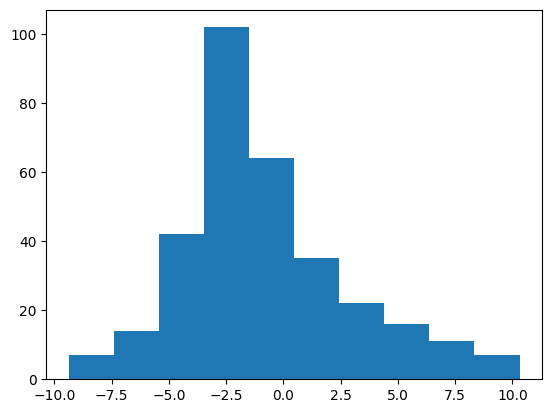

TIMESTEP: 349
Array((), dtype=key<fry>) overlaying:
[1312504256 1940210464]
TIMESTEP: 348
Array((), dtype=key<fry>) overlaying:
[1632657317  872130776]
TIMESTEP: 347
Array((), dtype=key<fry>) overlaying:
[ 123247721 1412217416]
TIMESTEP: 346
Array((), dtype=key<fry>) overlaying:
[2837075733 3336170298]
TIMESTEP: 345
Array((), dtype=key<fry>) overlaying:
[  62128847 1007924216]
TIMESTEP: 344
Array((), dtype=key<fry>) overlaying:
[1486404656 2853976811]
TIMESTEP: 343
Array((), dtype=key<fry>) overlaying:
[4213475019 3393490937]
TIMESTEP: 342
Array((), dtype=key<fry>) overlaying:
[2826540779 3816819689]
TIMESTEP: 341
Array((), dtype=key<fry>) overlaying:
[ 614507829 2055034187]
TIMESTEP: 340
Array((), dtype=key<fry>) overlaying:
[2761485083 2348781551]
TIMESTEP: 339
Array((), dtype=key<fry>) overlaying:
[2479437171 3706614240]
TIMESTEP: 338
Array((), dtype=key<fry>) overlaying:
[126279565 957803679]
TIMESTEP: 337
Array((), dtype=key<fry>) overlaying:
[ 175437031 2564538087]
TIMESTEP: 336


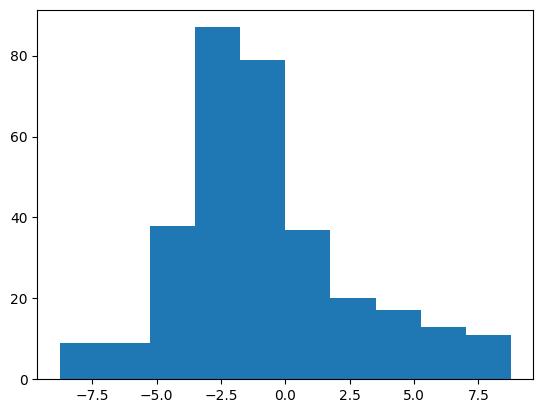

TIMESTEP: 324
Array((), dtype=key<fry>) overlaying:
[3219576457 3995821080]
TIMESTEP: 323
Array((), dtype=key<fry>) overlaying:
[3996276246 1928249882]
TIMESTEP: 322
Array((), dtype=key<fry>) overlaying:
[2291938724  406638946]
TIMESTEP: 321
Array((), dtype=key<fry>) overlaying:
[2325663915 4158005667]
TIMESTEP: 320
Array((), dtype=key<fry>) overlaying:
[2158586752 3639191838]
TIMESTEP: 319
Array((), dtype=key<fry>) overlaying:
[3097762825 1030913408]
TIMESTEP: 318
Array((), dtype=key<fry>) overlaying:
[1975139491  263807454]
TIMESTEP: 317
Array((), dtype=key<fry>) overlaying:
[1370076561 3768029540]
TIMESTEP: 316
Array((), dtype=key<fry>) overlaying:
[1106168675 1441800172]
TIMESTEP: 315
Array((), dtype=key<fry>) overlaying:
[2682583235 1054182291]
TIMESTEP: 314
Array((), dtype=key<fry>) overlaying:
[1597462917  399037915]
TIMESTEP: 313
Array((), dtype=key<fry>) overlaying:
[ 919106868 3642466076]
TIMESTEP: 312
Array((), dtype=key<fry>) overlaying:
[2287719382 4233963444]
TIMESTEP: 31

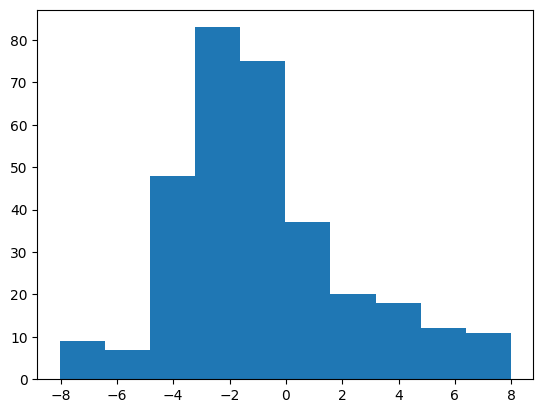

TIMESTEP: 299
Array((), dtype=key<fry>) overlaying:
[2378581729 2759032376]
TIMESTEP: 298
Array((), dtype=key<fry>) overlaying:
[3264135976 2433568567]
TIMESTEP: 297
Array((), dtype=key<fry>) overlaying:
[4264281129 1392962355]
TIMESTEP: 296
Array((), dtype=key<fry>) overlaying:
[ 180572251 1114921227]
TIMESTEP: 295
Array((), dtype=key<fry>) overlaying:
[1128579312 2441649930]
TIMESTEP: 294
Array((), dtype=key<fry>) overlaying:
[2119589455   93042017]
TIMESTEP: 293
Array((), dtype=key<fry>) overlaying:
[1348426929  328440613]
TIMESTEP: 292
Array((), dtype=key<fry>) overlaying:
[ 368429737 3951778487]
TIMESTEP: 291
Array((), dtype=key<fry>) overlaying:
[3245273777   64144627]
TIMESTEP: 290
Array((), dtype=key<fry>) overlaying:
[2138955516   10172345]
TIMESTEP: 289
Array((), dtype=key<fry>) overlaying:
[ 263597174 4017569799]
TIMESTEP: 288
Array((), dtype=key<fry>) overlaying:
[1167236305  502330464]
TIMESTEP: 287
Array((), dtype=key<fry>) overlaying:
[1219470625 1656737931]
TIMESTEP: 28

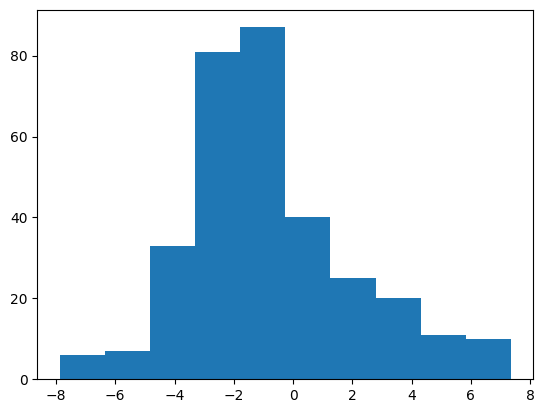

TIMESTEP: 274
Array((), dtype=key<fry>) overlaying:
[1500009214 3794201279]
TIMESTEP: 273
Array((), dtype=key<fry>) overlaying:
[2875925609 3465661852]
TIMESTEP: 272
Array((), dtype=key<fry>) overlaying:
[3915588166 2445334949]
TIMESTEP: 271
Array((), dtype=key<fry>) overlaying:
[2344776815 1091330732]
TIMESTEP: 270
Array((), dtype=key<fry>) overlaying:
[2443313592 1324579446]
TIMESTEP: 269
Array((), dtype=key<fry>) overlaying:
[3619040496 2602626311]
TIMESTEP: 268
Array((), dtype=key<fry>) overlaying:
[2251046944  866782493]
TIMESTEP: 267
Array((), dtype=key<fry>) overlaying:
[  63956672 1757416872]
TIMESTEP: 266
Array((), dtype=key<fry>) overlaying:
[2864626783  182987061]
TIMESTEP: 265
Array((), dtype=key<fry>) overlaying:
[4248995120 1090219316]
TIMESTEP: 264
Array((), dtype=key<fry>) overlaying:
[ 782014018 4096425372]
TIMESTEP: 263
Array((), dtype=key<fry>) overlaying:
[2826322594  799311898]
TIMESTEP: 262
Array((), dtype=key<fry>) overlaying:
[2570320023 2767689356]
TIMESTEP: 26

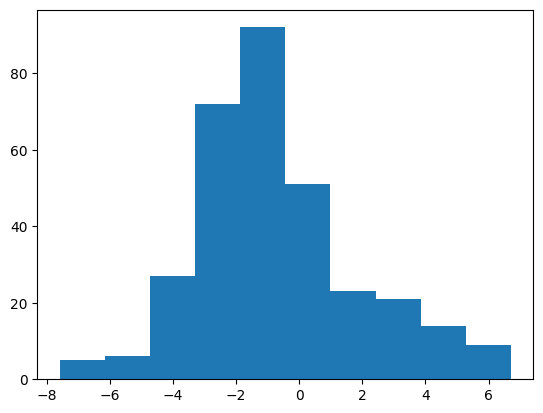

TIMESTEP: 249
Array((), dtype=key<fry>) overlaying:
[3669086719 3255879234]
TIMESTEP: 248
Array((), dtype=key<fry>) overlaying:
[3827251280 2553200399]
TIMESTEP: 247
Array((), dtype=key<fry>) overlaying:
[2158187176 3434118998]
TIMESTEP: 246
Array((), dtype=key<fry>) overlaying:
[2469616795 3406702426]
TIMESTEP: 245
Array((), dtype=key<fry>) overlaying:
[1087176043 1849009939]
TIMESTEP: 244
Array((), dtype=key<fry>) overlaying:
[1076781712  527250161]
TIMESTEP: 243
Array((), dtype=key<fry>) overlaying:
[3346249317 2804903235]
TIMESTEP: 242
Array((), dtype=key<fry>) overlaying:
[2470851754 3770338470]
TIMESTEP: 241
Array((), dtype=key<fry>) overlaying:
[3994011409  128992966]
TIMESTEP: 240
Array((), dtype=key<fry>) overlaying:
[4119314047 1348230621]
TIMESTEP: 239
Array((), dtype=key<fry>) overlaying:
[  31745898 1611059327]
TIMESTEP: 238
Array((), dtype=key<fry>) overlaying:
[2238831111 3767343136]
TIMESTEP: 237
Array((), dtype=key<fry>) overlaying:
[870522060 597991088]
TIMESTEP: 236


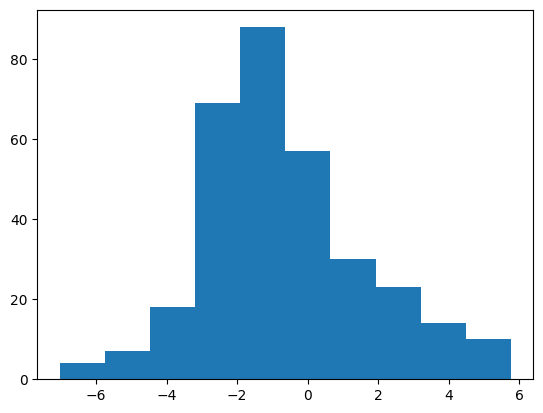

TIMESTEP: 224
Array((), dtype=key<fry>) overlaying:
[2469577305 2623055424]
TIMESTEP: 223
Array((), dtype=key<fry>) overlaying:
[2208927581 1477554384]
TIMESTEP: 222
Array((), dtype=key<fry>) overlaying:
[124765361 913601709]
TIMESTEP: 221
Array((), dtype=key<fry>) overlaying:
[1316019678 4085768764]
TIMESTEP: 220
Array((), dtype=key<fry>) overlaying:
[4095847112 3525024402]
TIMESTEP: 219
Array((), dtype=key<fry>) overlaying:
[3194417512 2187181309]
TIMESTEP: 218
Array((), dtype=key<fry>) overlaying:
[ 266606134 2479696264]
TIMESTEP: 217
Array((), dtype=key<fry>) overlaying:
[1631059174 2027977904]
TIMESTEP: 216
Array((), dtype=key<fry>) overlaying:
[ 583371343 2647043899]
TIMESTEP: 215
Array((), dtype=key<fry>) overlaying:
[1030744537 3100499044]
TIMESTEP: 214
Array((), dtype=key<fry>) overlaying:
[1409833655 4158364147]
TIMESTEP: 213
Array((), dtype=key<fry>) overlaying:
[1618944570 1834204552]
TIMESTEP: 212
Array((), dtype=key<fry>) overlaying:
[3514574032  742032281]
TIMESTEP: 211


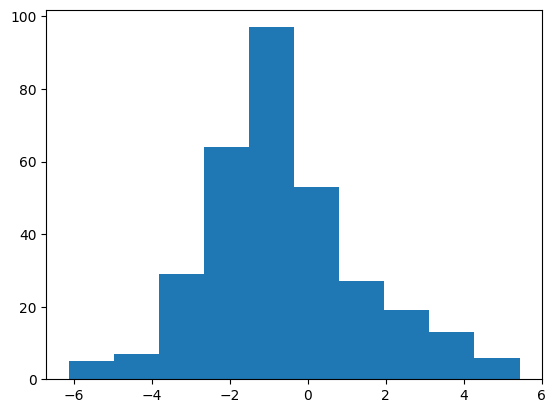

TIMESTEP: 199
Array((), dtype=key<fry>) overlaying:
[3107768426  307070281]
TIMESTEP: 198
Array((), dtype=key<fry>) overlaying:
[4128064814  238414282]
TIMESTEP: 197
Array((), dtype=key<fry>) overlaying:
[4255608746 4177302985]
TIMESTEP: 196
Array((), dtype=key<fry>) overlaying:
[1453230451 2932236553]
TIMESTEP: 195
Array((), dtype=key<fry>) overlaying:
[2495120522 1483503856]
TIMESTEP: 194
Array((), dtype=key<fry>) overlaying:
[2660805653 3139140722]
TIMESTEP: 193
Array((), dtype=key<fry>) overlaying:
[3652593347  265402921]
TIMESTEP: 192
Array((), dtype=key<fry>) overlaying:
[1673931496 3164767065]
TIMESTEP: 191
Array((), dtype=key<fry>) overlaying:
[474170595 689299216]
TIMESTEP: 190
Array((), dtype=key<fry>) overlaying:
[249371029 504161755]
TIMESTEP: 189
Array((), dtype=key<fry>) overlaying:
[441822271  12033247]
TIMESTEP: 188
Array((), dtype=key<fry>) overlaying:
[3764413443 2036898661]
TIMESTEP: 187
Array((), dtype=key<fry>) overlaying:
[1710162263 2395981884]
TIMESTEP: 186
Arra

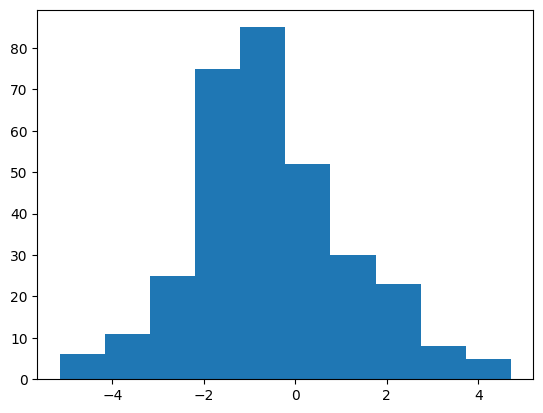

TIMESTEP: 174
Array((), dtype=key<fry>) overlaying:
[3828032592 1778503733]
TIMESTEP: 173
Array((), dtype=key<fry>) overlaying:
[1652954642  899622636]
TIMESTEP: 172
Array((), dtype=key<fry>) overlaying:
[ 909548077 3967383527]
TIMESTEP: 171
Array((), dtype=key<fry>) overlaying:
[ 638173416 3701935992]
TIMESTEP: 170
Array((), dtype=key<fry>) overlaying:
[3058853979  499552086]
TIMESTEP: 169
Array((), dtype=key<fry>) overlaying:
[410255026 175822987]
TIMESTEP: 168
Array((), dtype=key<fry>) overlaying:
[3071814126  513664097]
TIMESTEP: 167
Array((), dtype=key<fry>) overlaying:
[3394249826 1973721780]
TIMESTEP: 166
Array((), dtype=key<fry>) overlaying:
[1497643969 2383223682]
TIMESTEP: 165
Array((), dtype=key<fry>) overlaying:
[4248988439 1805997902]
TIMESTEP: 164
Array((), dtype=key<fry>) overlaying:
[ 736516520 4219690315]
TIMESTEP: 163
Array((), dtype=key<fry>) overlaying:
[153861594 550489228]
TIMESTEP: 162
Array((), dtype=key<fry>) overlaying:
[ 758094401 3949095920]
TIMESTEP: 161
Ar

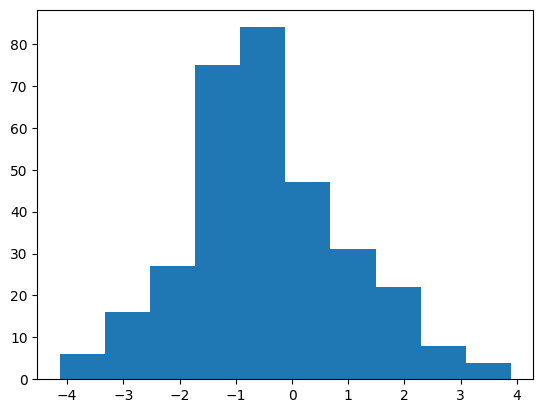

TIMESTEP: 149
Array((), dtype=key<fry>) overlaying:
[1852699526 4072594564]
TIMESTEP: 148
Array((), dtype=key<fry>) overlaying:
[3364556482 3529210013]
TIMESTEP: 147
Array((), dtype=key<fry>) overlaying:
[1631938194 3508448340]
TIMESTEP: 146
Array((), dtype=key<fry>) overlaying:
[1486633357  803639597]
TIMESTEP: 145
Array((), dtype=key<fry>) overlaying:
[ 268492867 3348639168]
TIMESTEP: 144
Array((), dtype=key<fry>) overlaying:
[869016871 693324873]
TIMESTEP: 143
Array((), dtype=key<fry>) overlaying:
[ 670728281 2325575929]
TIMESTEP: 142
Array((), dtype=key<fry>) overlaying:
[4243397912 1368661068]
TIMESTEP: 141
Array((), dtype=key<fry>) overlaying:
[1155118634 3165927560]
TIMESTEP: 140
Array((), dtype=key<fry>) overlaying:
[2535028735 3014465015]
TIMESTEP: 139
Array((), dtype=key<fry>) overlaying:
[2868501873 2665384793]
TIMESTEP: 138
Array((), dtype=key<fry>) overlaying:
[3157891325 4276839244]
TIMESTEP: 137
Array((), dtype=key<fry>) overlaying:
[1031471506 1458321828]
TIMESTEP: 136


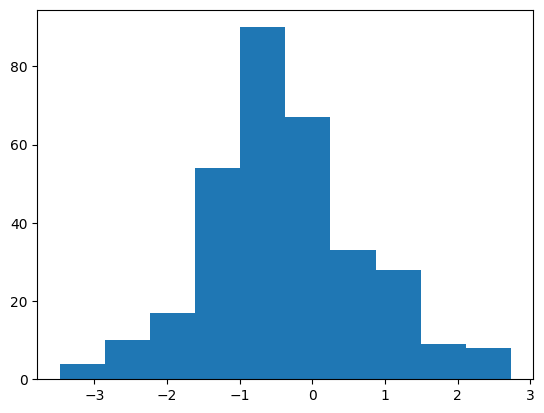

TIMESTEP: 124
Array((), dtype=key<fry>) overlaying:
[1043688385  847626483]
TIMESTEP: 123
Array((), dtype=key<fry>) overlaying:
[2201726692  936208440]
TIMESTEP: 122
Array((), dtype=key<fry>) overlaying:
[3693054216 2688804080]
TIMESTEP: 121
Array((), dtype=key<fry>) overlaying:
[2943600919  888120790]
TIMESTEP: 120
Array((), dtype=key<fry>) overlaying:
[1225722126 2139644055]
TIMESTEP: 119
Array((), dtype=key<fry>) overlaying:
[ 598326399 3324187002]
TIMESTEP: 118
Array((), dtype=key<fry>) overlaying:
[4121977976 1231672832]
TIMESTEP: 117
Array((), dtype=key<fry>) overlaying:
[ 938453982 1373630673]
TIMESTEP: 116
Array((), dtype=key<fry>) overlaying:
[ 276908834 1811199148]
TIMESTEP: 115
Array((), dtype=key<fry>) overlaying:
[2603074077 2417202413]
TIMESTEP: 114
Array((), dtype=key<fry>) overlaying:
[4055500163  942275401]
TIMESTEP: 113
Array((), dtype=key<fry>) overlaying:
[ 242849977 1348106339]
TIMESTEP: 112
Array((), dtype=key<fry>) overlaying:
[1701850133 3804481935]
TIMESTEP: 11

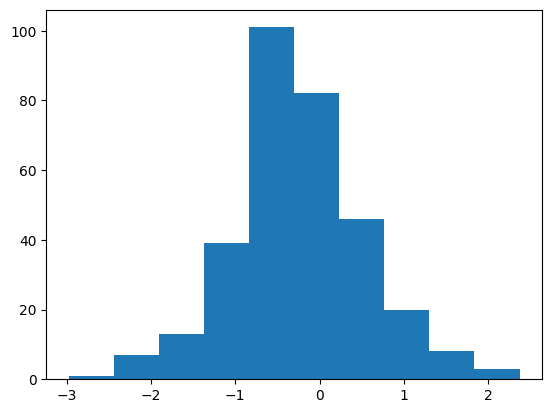

TIMESTEP: 99
Array((), dtype=key<fry>) overlaying:
[3869180048  790651588]
TIMESTEP: 98
Array((), dtype=key<fry>) overlaying:
[3225060185  774482751]
TIMESTEP: 97
Array((), dtype=key<fry>) overlaying:
[3167354179 1425603778]
TIMESTEP: 96
Array((), dtype=key<fry>) overlaying:
[1066781301 3992495894]
TIMESTEP: 95
Array((), dtype=key<fry>) overlaying:
[  42158944 4194864415]
TIMESTEP: 94
Array((), dtype=key<fry>) overlaying:
[1705177505 3288091302]
TIMESTEP: 93
Array((), dtype=key<fry>) overlaying:
[2515948904 2354821129]
TIMESTEP: 92
Array((), dtype=key<fry>) overlaying:
[1894870662 2800036289]
TIMESTEP: 91
Array((), dtype=key<fry>) overlaying:
[1462530930 1573288424]
TIMESTEP: 90
Array((), dtype=key<fry>) overlaying:
[2635341823  366785917]
TIMESTEP: 89
Array((), dtype=key<fry>) overlaying:
[1677477502  861588516]
TIMESTEP: 88
Array((), dtype=key<fry>) overlaying:
[2314811068 3501881931]
TIMESTEP: 87
Array((), dtype=key<fry>) overlaying:
[3914809101 1613509436]
TIMESTEP: 86
Array((), dt

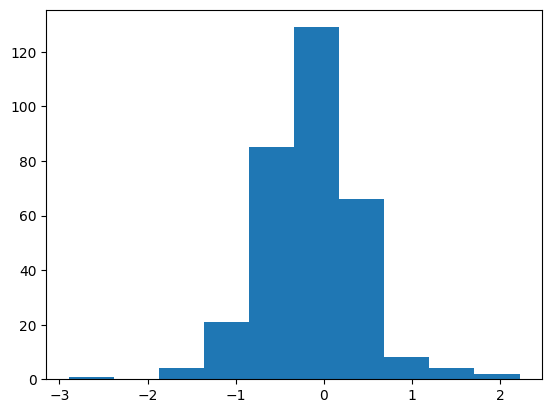

TIMESTEP: 74
Array((), dtype=key<fry>) overlaying:
[  84509001 3220167583]
TIMESTEP: 73
Array((), dtype=key<fry>) overlaying:
[1919190587 1112000827]
TIMESTEP: 72
Array((), dtype=key<fry>) overlaying:
[ 188817469 1019579076]
TIMESTEP: 71
Array((), dtype=key<fry>) overlaying:
[1292832996 3031780747]
TIMESTEP: 70
Array((), dtype=key<fry>) overlaying:
[2853121716 2866584817]
TIMESTEP: 69
Array((), dtype=key<fry>) overlaying:
[3967063431 1168221475]
TIMESTEP: 68
Array((), dtype=key<fry>) overlaying:
[3718389103 3197842234]
TIMESTEP: 67
Array((), dtype=key<fry>) overlaying:
[ 692644120 2010812096]
TIMESTEP: 66
Array((), dtype=key<fry>) overlaying:
[ 391314315 3002910174]
TIMESTEP: 65
Array((), dtype=key<fry>) overlaying:
[2977741684 3199424728]
TIMESTEP: 64
Array((), dtype=key<fry>) overlaying:
[2071555808 1099097266]
TIMESTEP: 63
Array((), dtype=key<fry>) overlaying:
[3825675793 2924414974]
TIMESTEP: 62
Array((), dtype=key<fry>) overlaying:
[ 387404561 2774990073]
TIMESTEP: 61
Array((), dt

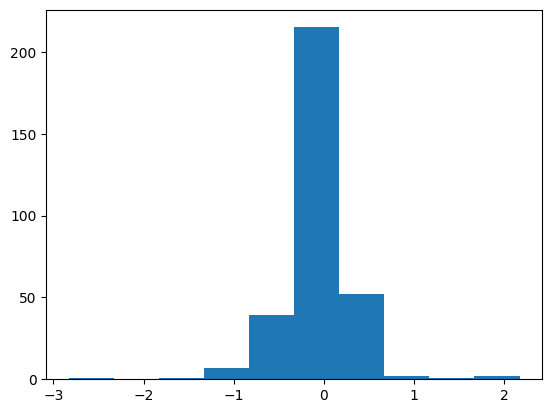

TIMESTEP: 49
Array((), dtype=key<fry>) overlaying:
[694563053 565037248]
TIMESTEP: 48
Array((), dtype=key<fry>) overlaying:
[ 469201209 3869166682]
TIMESTEP: 47
Array((), dtype=key<fry>) overlaying:
[3779227920 2500028513]
TIMESTEP: 46
Array((), dtype=key<fry>) overlaying:
[3252049002  185003699]
TIMESTEP: 45
Array((), dtype=key<fry>) overlaying:
[2126745282 2216803760]
TIMESTEP: 44
Array((), dtype=key<fry>) overlaying:
[1262817412 1717403663]
TIMESTEP: 43
Array((), dtype=key<fry>) overlaying:
[3794578083 1022734708]
TIMESTEP: 42
Array((), dtype=key<fry>) overlaying:
[2211432334 3705914574]
TIMESTEP: 41
Array((), dtype=key<fry>) overlaying:
[ 735619831 1966671808]
TIMESTEP: 40
Array((), dtype=key<fry>) overlaying:
[1445661783 2931814393]
TIMESTEP: 39
Array((), dtype=key<fry>) overlaying:
[ 105769557 1438215856]
TIMESTEP: 38
Array((), dtype=key<fry>) overlaying:
[2159838289  862736703]
TIMESTEP: 37
Array((), dtype=key<fry>) overlaying:
[2370840561 2295175711]
TIMESTEP: 36
Array((), dtyp

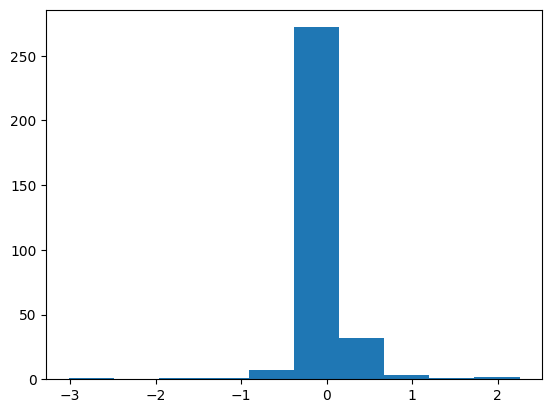

TIMESTEP: 24
Array((), dtype=key<fry>) overlaying:
[3027892908 1230779856]
TIMESTEP: 23
Array((), dtype=key<fry>) overlaying:
[885845384 907622475]
TIMESTEP: 22
Array((), dtype=key<fry>) overlaying:
[2621781623  127663271]
TIMESTEP: 21
Array((), dtype=key<fry>) overlaying:
[ 947303526 3824829994]
TIMESTEP: 20
Array((), dtype=key<fry>) overlaying:
[1762793429 2606886830]
TIMESTEP: 19
Array((), dtype=key<fry>) overlaying:
[3675833703 3952187407]
TIMESTEP: 18
Array((), dtype=key<fry>) overlaying:
[2032779694 1150722666]
TIMESTEP: 17
Array((), dtype=key<fry>) overlaying:
[1012875396 1400875963]
TIMESTEP: 16
Array((), dtype=key<fry>) overlaying:
[2605709881 2086839404]
TIMESTEP: 15
Array((), dtype=key<fry>) overlaying:
[3514361847  786973558]
TIMESTEP: 14
Array((), dtype=key<fry>) overlaying:
[1640525198 1295658099]
TIMESTEP: 13
Array((), dtype=key<fry>) overlaying:
[4293956271 2136704254]
TIMESTEP: 12
Array((), dtype=key<fry>) overlaying:
[2421217736 2344845533]
TIMESTEP: 11
Array((), dtyp

ValueError: cannot select an axis to squeeze out which has size not equal to one, got shape=(10, 2, 16, 1) and dimensions=(0,)

In [ ]:
# Generating Gaussian noise
rng, key = random.split(rng)
x = random.normal(key, shape=(10, 2, 16, 1))
timesteps = 500

plt.hist(x.flatten())
plt.show()
# Create a list to store output images
img_list_ddpm = []

# Append the initial noise to the list of images
# im = decoder_model.apply({"params": decoder_params}, x[:, :, :, 0])
# # print(im)
# #img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))

# plt.imshow(im[0, 0, :, :, 2], cmap='gray')
# plt.colorbar()
# plt.show()

plt.hist(x.flatten())
plt.show()


# Iterate over T timesteps
for i in range(0, timesteps - 1):
    # t-th timestep
    prev_x = x
    subkey = random.fold_in(key, i)
    print(subkey)
    t = jnp.expand_dims(jnp.array(timesteps - i - 1, jnp.int32), 0)

    # Predict noise using U-Net

    noise = vmapped_unet(UNet_pararms, x, t)
    #     #plt.imshow(noise[0, :, :, 2], cmap='gray')
    #     plt.colorbar()
    #     plt.show()

    if i < 0:
        x = backward_denoising_ddpm(subkey, x, noise, t)
    # Obtain the output from the noise using the formula seen before
    else:
        x, x1, x0, random_o = inverse_prob_ddpm_step(
            input_key=subkey,
            x_t=x,
            pred_noise=noise,
            t=t,
            y=jnp.expand_dims(noisy_field, 0),
            latent_scaling_factor=config.latent_scaling_factor,
            noise_sigma=config.vae_config.noise_sigma,
            decoder_params=decoder_params,
            input_shape=config.vae_config.input_shape,
            latent_dim=config.vae_config.latent_dim,
            decoder_filters=config.vae_config.decoder_filters,
            decoder_kernels=config.vae_config.decoder_kernels,
            dense_layer_units=config.vae_config.dense_layer_units,
            padding_infos=padding_infos,
        )

    #         plt.hist(x0.flatten())
    #         plt.show()
    #         plt.title("x_0")
    # Log the image after every 25 iterations
    if i % 25 == 0:
        plt.hist(x.flatten())
        plt.show()

    #     plt.hist((x-x1).flatten())
    #     plt.show()

    print("TIMESTEP: " + str(timesteps - i - 1))

#     im = decoder_model.apply({"params": decoder_params}, x[0]/config.latent_scaling_factor -1)
# print(im)
# img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))

#     plt.imshow(im[0, 0, :, :, 3], cmap='gray')
#     plt.colorbar()
#     plt.show()

# Display the final generated image
plt.imshow(jnp.squeeze(jnp.squeeze(x, 0), -1), cmap="gray")
plt.show()

# Save generated GIF
# save_gif(img_list_ddpm, path="output_ddpm.gif")#

In [ ]:
im = []
for i in range(10):
    im.append(decoder_model.apply({"params": decoder_params}, x[0, :, :, 0]))

In [ ]:
im = jnp.asarray(im)

In [ ]:
x[:, :, :, 0].shape

(10, 2, 16)

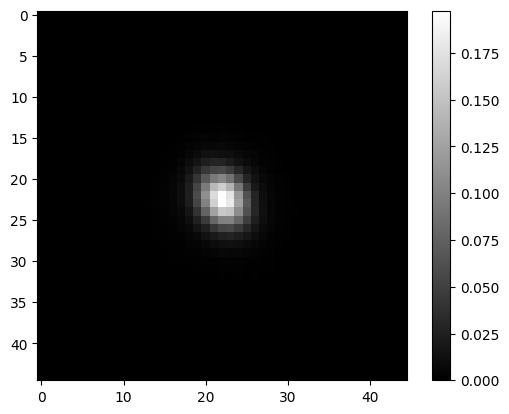

In [ ]:
plt.imshow(im[0, 0, :, :, 3], cmap="gray")
plt.colorbar()
plt.show()

In [ ]:
def reconst_field(x, padding_infos):
    galaxies = decoder_model.apply({"params": decoder_params}, x[:, :, 0])
    reconst_field = jnp.pad(galaxies[0], padding_infos[0])
    for i in range(len(padding_infos) - 1):
        reconst_field += jnp.pad(galaxies[i + 1], padding_infos[i + 1])
    return reconst_field, galaxies

In [ ]:
reconst_field, galaxies = jax.vmap(reconst_field, (0, None))(x, padding_infos)

In [ ]:
reconst_field.shape

(10, 68, 69, 6)

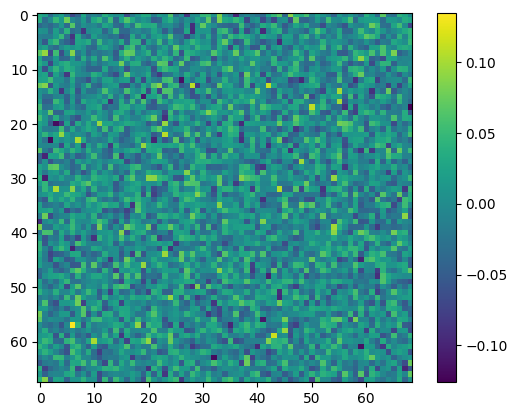

In [ ]:
filt_num = 2
plt.imshow((noisy_field - jnp.mean(reconst_field, axis=0))[:, :, filt_num])
plt.colorbar()

In [ ]:
reconst_field;

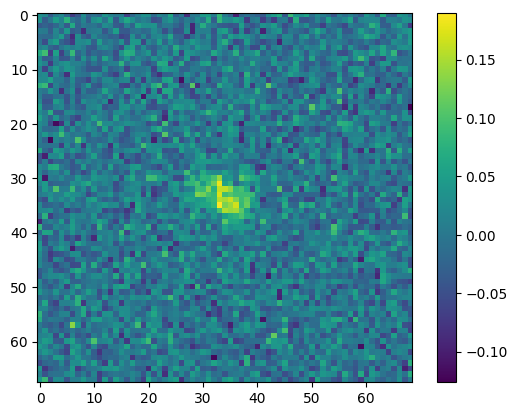

In [ ]:
plt.imshow(noisy_field[:, :, 2])
plt.colorbar()

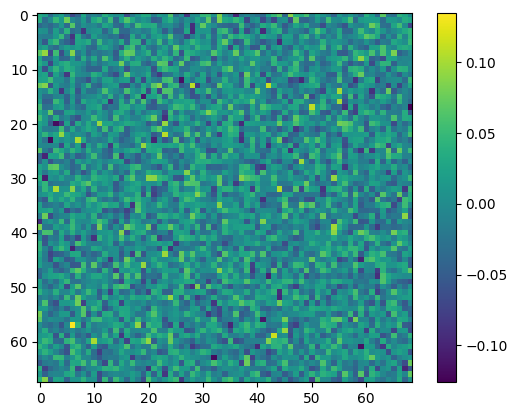

In [ ]:
filt_num = 2
plt.imshow(
    noisy_field[:, :, filt_num] - jnp.mean(reconst_field, axis=0)[:, :, filt_num]
)
plt.colorbar()

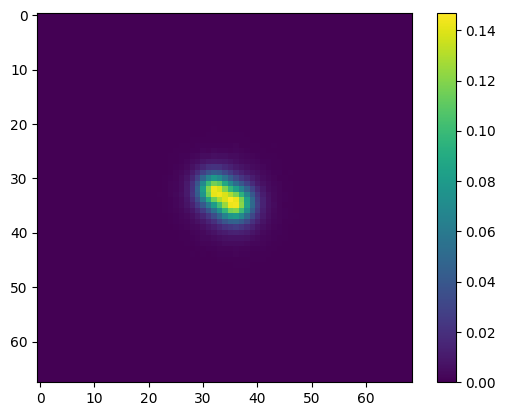

In [ ]:
plt.imshow(jnp.mean(reconst_field, axis=0)[:, :, filt_num])
plt.colorbar()

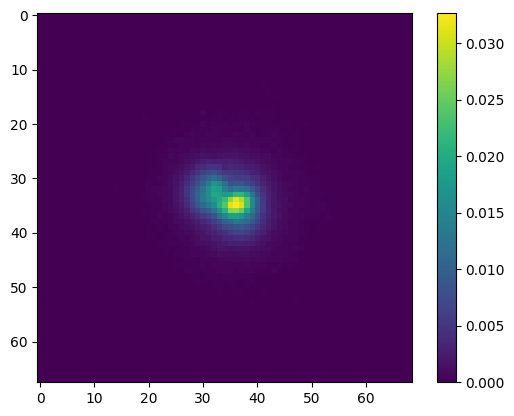

In [ ]:
plt.imshow(jnp.std(reconst_field, axis=0)[:, :, filt_num])
plt.colorbar()

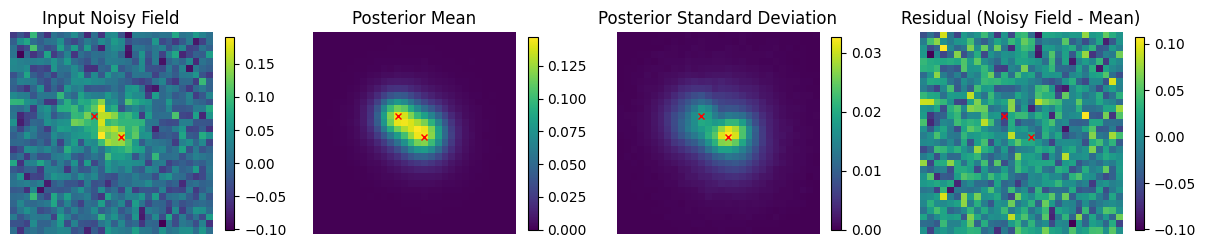

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

im = axs[0].imshow(noisy_field[:, :, filt_num][20:50, 20:50])
axs[0].plot(12, 12, marker="x", markersize=5, color="red")
axs[0].plot(16, 15, marker="x", markersize=5, color="red")
fig.colorbar(im, shrink=0.5)
axs[0].set_title("Input Noisy Field")
axs[0].set_axis_off()

im = axs[1].imshow(jnp.mean(reconst_field, axis=0)[:, :, filt_num][20:50, 20:50])
fig.colorbar(im, shrink=0.5)
axs[1].plot(12, 12, marker="x", markersize=5, color="red")
axs[1].plot(16, 15, marker="x", markersize=5, color="red")
axs[1].set_title("Posterior Mean")
# axs[1].set_title("Noisy added after {timestamps[im_to_display]} steps")
axs[1].set_axis_off()


im = axs[2].imshow(jnp.std(reconst_field, axis=0)[:, :, filt_num][20:50, 20:50])
fig.colorbar(im, shrink=0.5)
axs[2].plot(12, 12, marker="x", markersize=5, color="red")
axs[2].plot(16, 15, marker="x", markersize=5, color="red")
axs[2].set_title("Posterior Standard Deviation")
axs[2].set_axis_off()

im = axs[3].imshow(
    noisy_field[:, :, filt_num][20:50, 20:50]
    - jnp.mean(reconst_field, axis=0)[:, :, filt_num][20:50, 20:50]
)
fig.colorbar(im, shrink=0.5)
axs[3].plot(12, 12, marker="x", markersize=5, color="red")
axs[3].plot(16, 15, marker="x", markersize=5, color="red")
axs[3].set_title("Residual (Noisy Field - Mean)")
axs[3].set_axis_off()

plt.savefig(
    os.path.join("results", "deblending-example.pdf"),
    format="pdf",
    bbox_inches="tight",
)